# EDA (Exploratory Data Analysis)

here, we will clean, manipulate, and get an idea of what our dataset looks like; what are the features? 

In other words, what exactly are we working with?

A more thorough breakdown 

Data Loading and Preprocessing:
- Load the dataset.
- Handle missing values (if any).
- Convert possession time from HH:MM to total minutes.
- Use info() and describe() to understand data types and distributions.
- Identify important columns and relationships.

Exploratory Visualizations:
- Distributions (e.g., scores, possession time).
- Scatter plots (e.g., possession time vs. scores).
- Correlation heatmap.

Feature Comparisons by Win/Loss:
- Compare features like possession time, interceptions, yards per play, and red zone efficiency.

Outlier Analysis and Treatment:
- Flag and optionally exclude outliers for metrics like scores and turnovers.
- Save a filtered dataset if necessary.

Class Balance Check:
- Check and visualize the balance of win_loss_home

let's start with some data preprocessing

In [37]:
import pandas as pd
import numpy as np

data = pd.read_csv('../data/nfl_team_stats_2002-2023.csv')

#overview of the data
print(data.head())
print(data.info())
print(data.describe())

   season week        date  time_et  neutral       away        home  \
0    2002    1  2002-09-05  8:30 PM    False      49ers      Giants   
1    2002    1  2002-09-08  1:00 PM    False      Colts     Jaguars   
2    2002    1  2002-09-08  1:00 PM    False  Cardinals  Commanders   
3    2002    1  2002-09-08  1:00 PM    False      Lions    Dolphins   
4    2002    1  2002-09-08  1:00 PM    False     Eagles      Titans   

   score_away  score_home  first_downs_away  ...  redzone_comp_home  \
0          16          13                13  ...                  0   
1          28          25                18  ...                  0   
2          23          31                14  ...                  0   
3          21          49                15  ...                  0   
4          24          27                17  ...                  0   

   redzone_att_home  fumbles_away  fumbles_home  interceptions_away  \
0                 6             0             0                   1   
1   

Based on that, here's a breakdown:

Number of Entries: 5,929 rows, which likely correspond to individual games.
Number of Features: 61 columns, including season, team names, scores, and various game statistics.

Data Types:
- Numerical (int64): Most columns are integers (e.g., scores, yardage, turnovers).
- Categorical (object): Columns like week, date, away, and home.
- Boolean: The neutral column indicates whether the game was played on neutral ground.

Notable Columns
Identifiers:
- season: The year of the game.
- week: Week of the NFL season.
- date and time_et: Game date and time.
- away and home: Names of the teams.


Performance Metrics:
Team Scores:
- score_away and score_home: Final scores for away and home teams.

Yardage:
- yards_away and yards_home: Total yardage gained by each team.
     - Includes breakdowns like pass_yards, rush_yards, and sacks_yards.

Turnovers:
- fumbles_away, fumbles_home, interceptions_away, interceptions_home.

Possession Time:
- possession_away and possession_home (formatted as HH).

Red Zone Efficiency:
- redzone_comp_away and redzone_att_away (and home counterparts).

Game Events:
- def_st_td_away and def_st_td_home: Defensive/special teams touchdowns.

Furthermore, here's some possible conclusions from the data loading:

No Missing Data:
- The dataset shows zero null values across all columns (all show 5929 value, so no missing), which simplifies preprocessing.

Data Distribution:
- Scores: Averages are around 21 for away teams and around 23 for home teams, suggesting that home teams may have an advantage.
- Turnovers: Median values are low, but outliers (e.g., max interceptions = 6) could influence outcomes.
- Possession Time: Needs conversion from HH to numerical format for analysis.

Outliers:
- Max scores (70 points) and turnovers (6 interceptions) may indicate unusual games that should be flagged for further investigation.

In [38]:
def time_to_seconds(possession):
    """
    Convert possession time from MM:SS format to total seconds.
    MM:SS format means the first part is minutes, and the second part is seconds.
    """
    # Split the string on ':' to separate minutes and seconds
    parts = possession.split(':')
    
    # Convert minutes to seconds and add seconds
    total_seconds = int(parts[0]) * 60 + int(parts[1])
    
    return total_seconds

# Apply the function to both possession columns
data['possession_away'] = data['possession_away'].apply(time_to_seconds)
data['possession_home'] = data['possession_home'].apply(time_to_seconds)

# Check the result
print(data[['possession_away', 'possession_home']].head())


   possession_away  possession_home
0             1652             1948
1             1647             1953
2             1536             2064
3             1536             2064
4             1752             1848


### Why Convert Possession Time?

The possession_away and possession_home columns are initially formatted as strings in HH:MM (hours and minutes). 
While this format is readable for us, it can't be used directly in our model.

**After further inspection**, the format is **MM:SS**, where the first part represents minutes and the second part represents seconds.
- The conversion has been adjusted to reflect this format, producing possession times in **total seconds**.

So:

A possession time of 27:32 (27 minutes and 32 seconds) becomes:

Total Seconds = (27 × 60) + 32 = **1652**


Now, let's do a little more investigating, this time visually

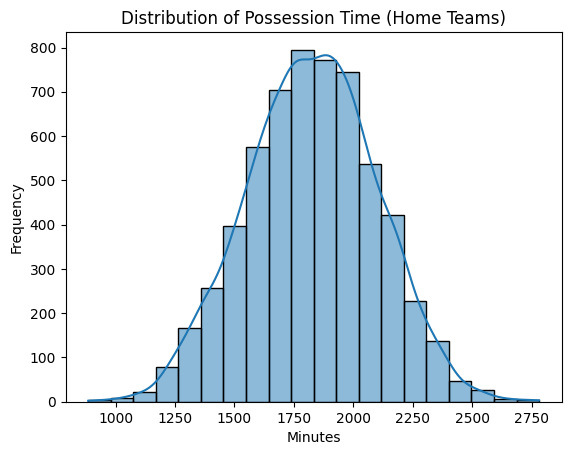

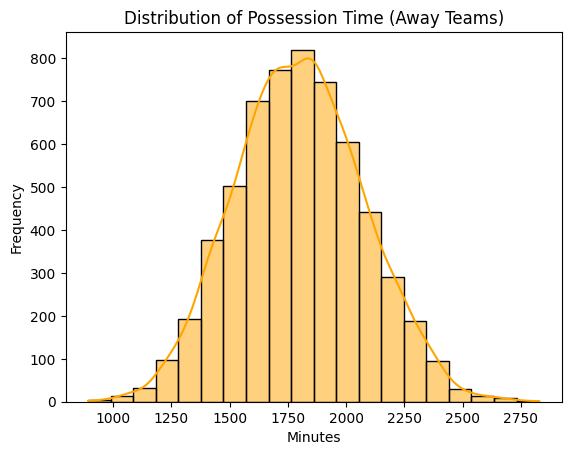

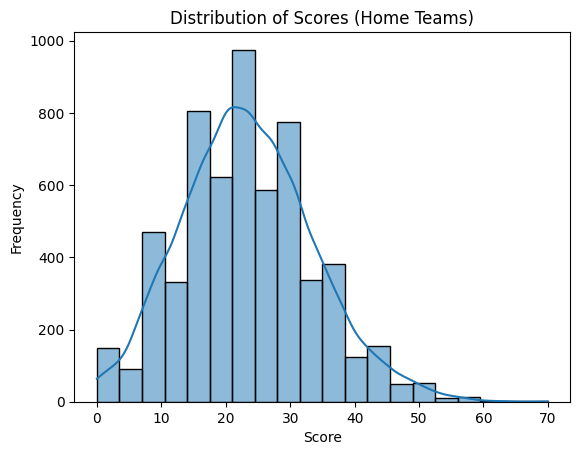

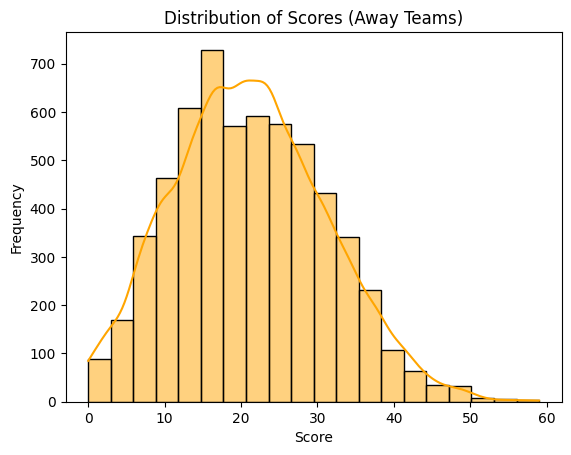

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of possession times
sns.histplot(data['possession_home'], kde=True, bins=20)
plt.title('Distribution of Possession Time (Home Teams)')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.show()

sns.histplot(data['possession_away'], kde=True, bins=20, color = 'orange')
plt.title('Distribution of Possession Time (Away Teams)')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.show()

# Distribution of scores
sns.histplot(data['score_home'], kde=True, bins=20)
plt.title('Distribution of Scores (Home Teams)')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

sns.histplot(data['score_away'], kde=True, bins=20, color='orange')
plt.title('Distribution of Scores (Away Teams)')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

### Observations: Distribution of Possession Time and Scores

1. Possession Time:
   - for both home and away teams, the data seems concentrated within the 1500 - 2000 mark, which could infer that being home or away has little effect in possession time

2. Scores:
   1. **Home Teams**:
      - Home team scores peak around 17-30 points, with a few high-scoring outliers above 50 points.
      - The distribution supports the hypothesis of a home-field scoring advantage.

   2. **Away Teams**:
      - Away team scores are slightly lower on average, with most scores falling between 14-27 points.
      - This disparity highlights the challenges of playing away games.

let's also look at correlation between features

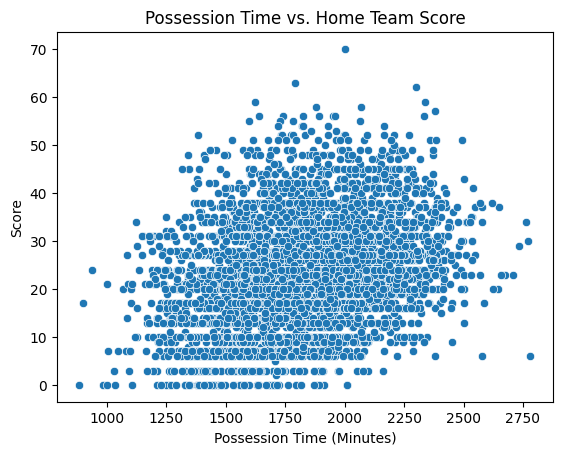

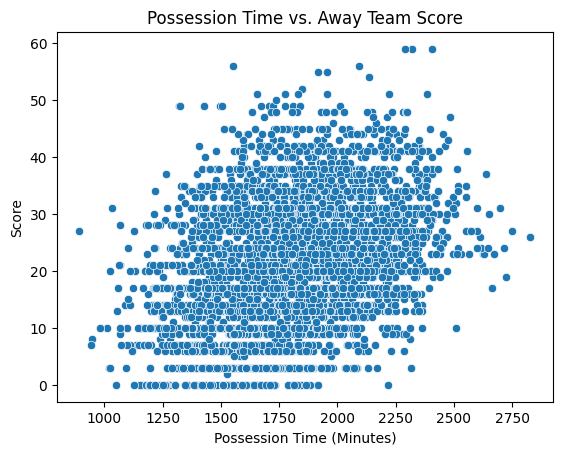

In [40]:
# Scatter plot: possession time vs. scores
sns.scatterplot(x='possession_home', y='score_home', data=data)
plt.title('Possession Time vs. Home Team Score')
plt.xlabel('Possession Time (Minutes)')
plt.ylabel('Score')
plt.show()

sns.scatterplot(x='possession_away', y='score_away', data=data)
plt.title('Possession Time vs. Away Team Score')
plt.xlabel('Possession Time (Minutes)')
plt.ylabel('Score')
plt.show()

### Observations: Possession Time vs. Team Score
1. **Home Teams**:
   - A weak positive correlation exists between possession time and home team scores.
   - Teams with longer possession times tend to score more, but possession time alone doesn't explain score variability.

2. **Away Teams**:
   - A similar weak positive correlation is observed, though the effect is slightly weaker than for home teams.
   - Away teams with higher possession times may perform better offensively, but other factors are likely more significant.

in shorter terms:
- The scatter plot reveals a weak positive correlation between possession time and home team scores.
- While teams with higher possession times tend to score slightly more, possession time alone does not fully explain score variability.

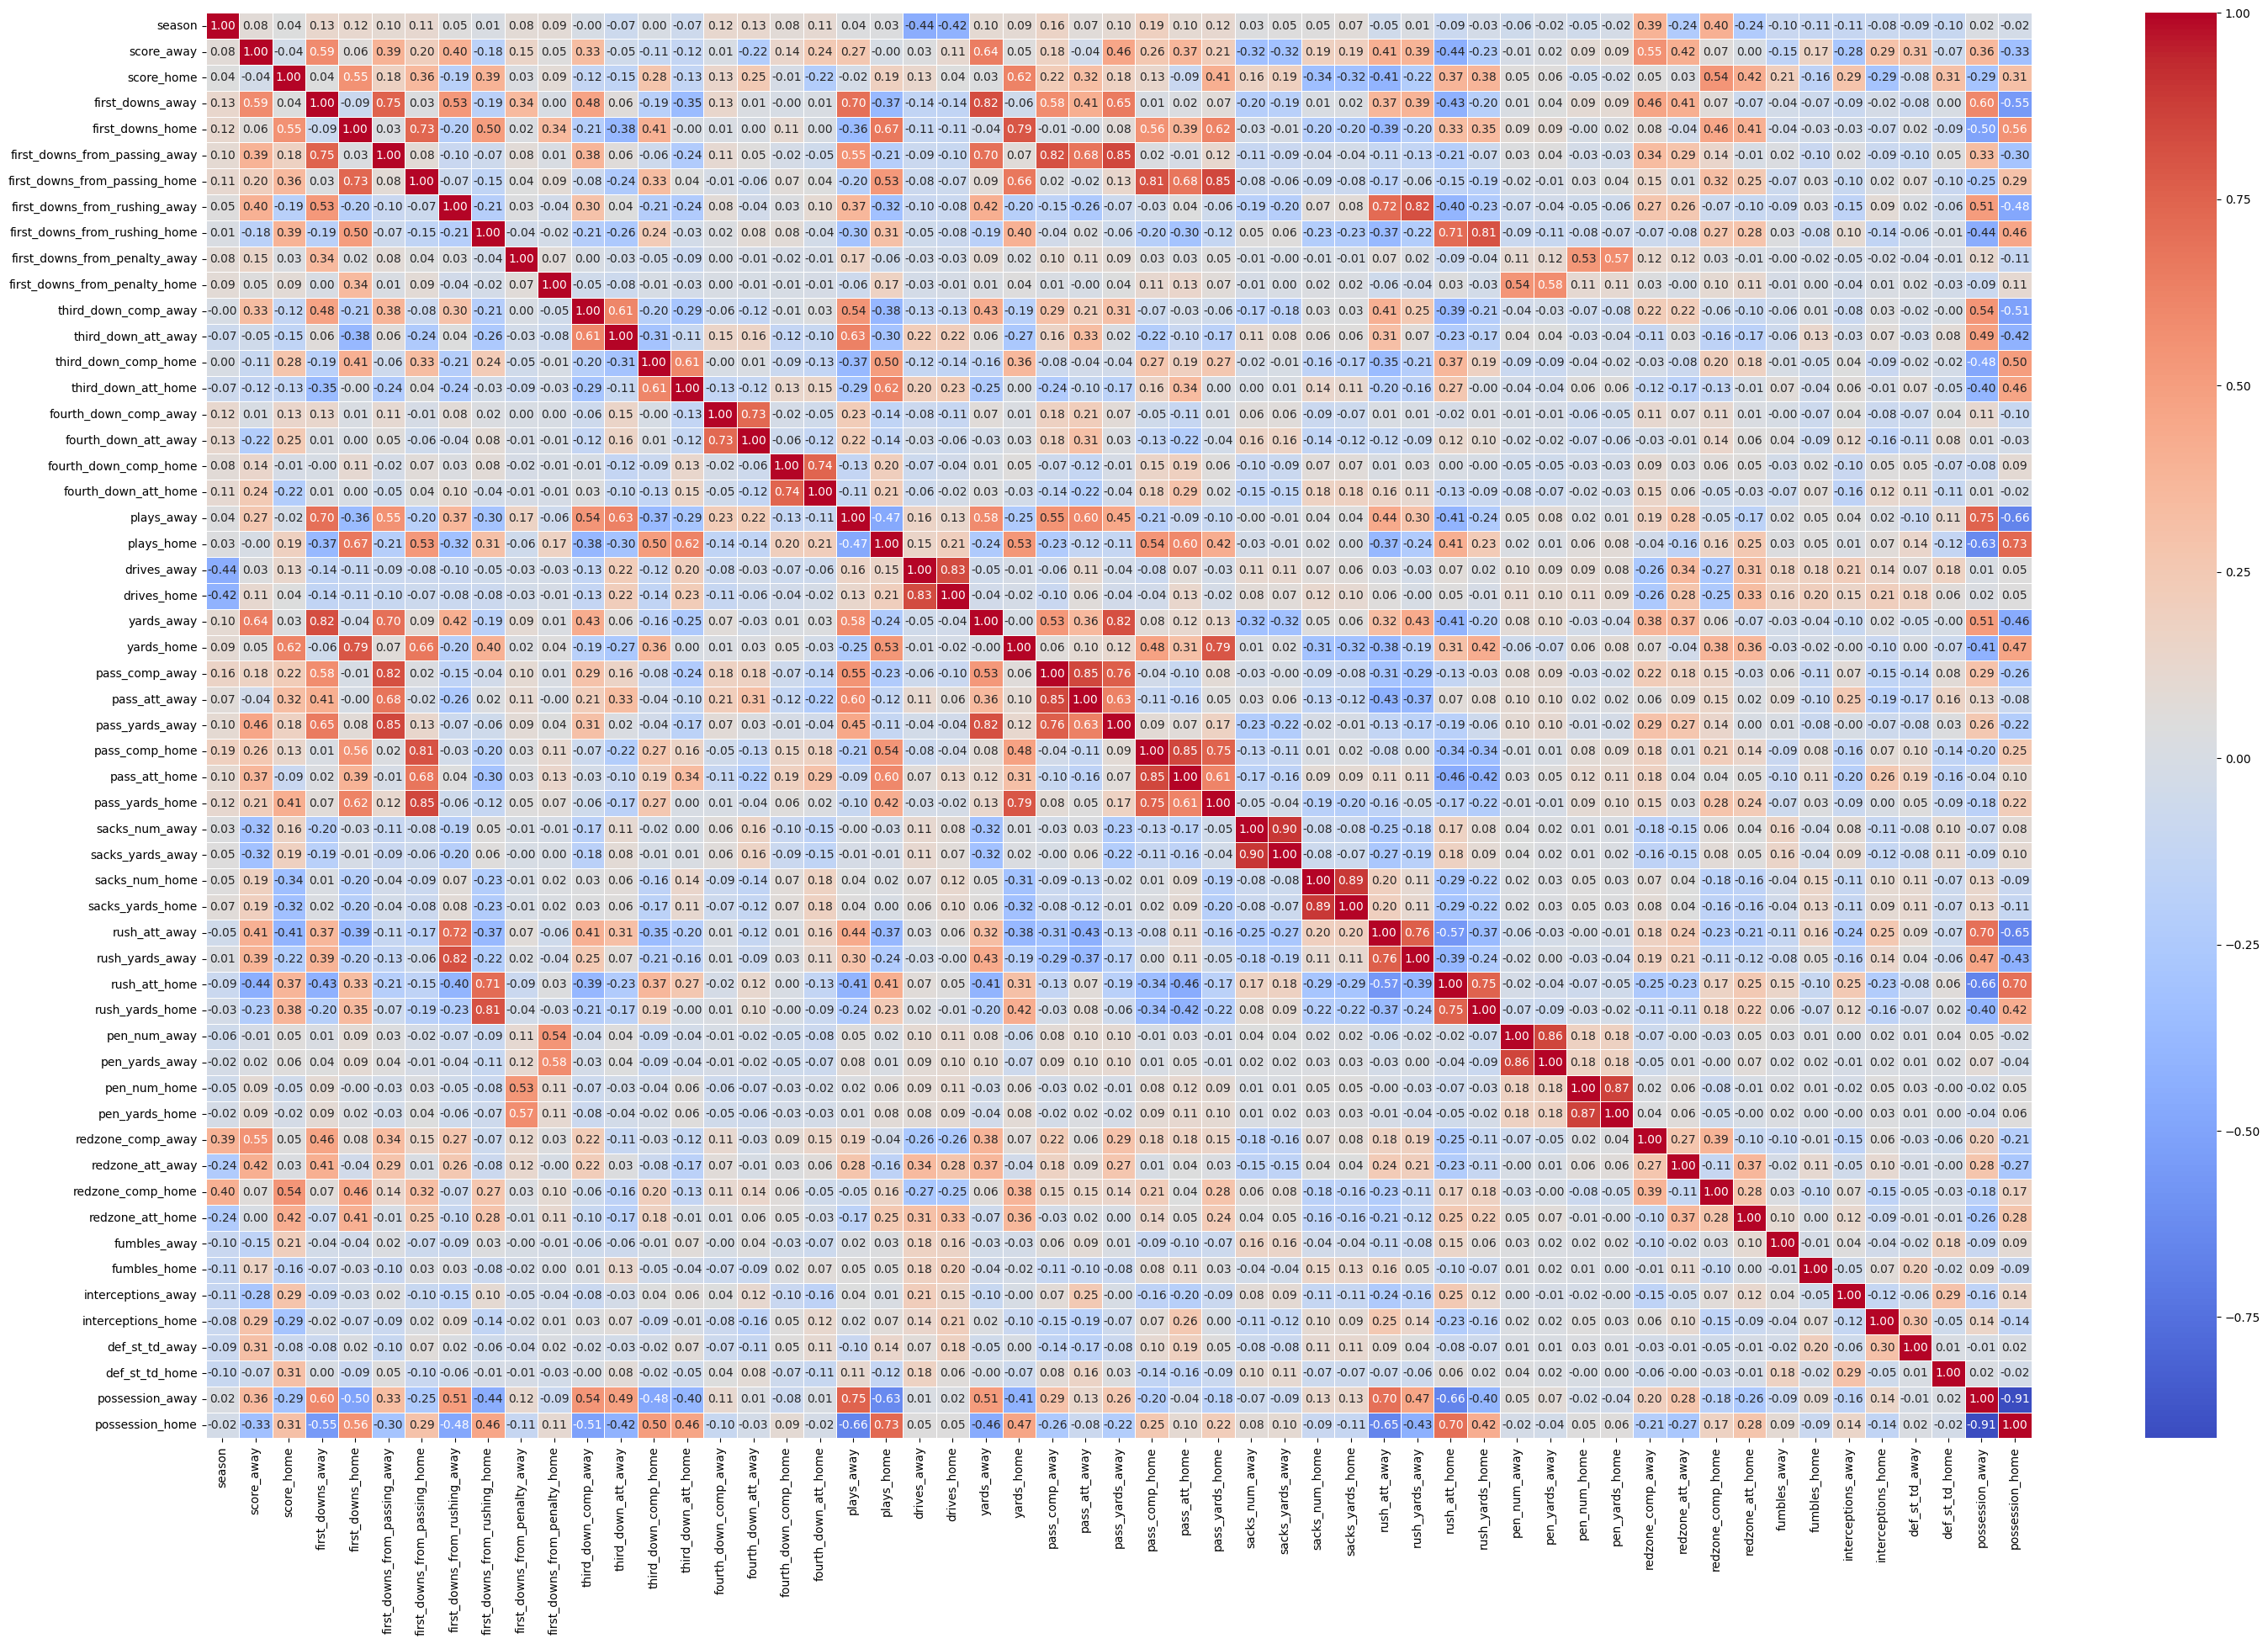

In [41]:
#select only numeric columns
numeric_data = data.select_dtypes(include=['number'])

#correlation heatmap
'''
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()
'''

#looked up some of these because the decimals weren't fitting/visible
plt.figure(figsize=(35, 22))  # Larger figure for better readability
heatmap = sns.heatmap(
    numeric_data.corr(), 
    annot=True, 
    fmt=".2f",  # Limit to 2 decimal places
    annot_kws={"size": 10},  # Annotation font size
    cmap='coolwarm', 
    linewidths=0.5  # Add lines between cells for better separation
)

### Observations: Correlation Heatmap

- Strong Correlations:
  - Home team possession time is moderately correlated with score_home (around 0.3), indicating that longer possession generally leads to higher scores.
  - Other metrics like yards_home and pass_yards_home show strong correlations with score_home (around 0.6-0.7), highlighting the importance of offensive yardage in determining scores.

- Negative Correlations:
  - Defensive metrics like interceptions_home and sacks_yards_away show weak to moderate negative correlations with scores, as turnovers typically hinder scoring opportunities.

- Weak/No Correlations:
  - Some metrics, such as penalties, show little to no correlation with scores, indicating they may not significantly impact overall game outcomes.


okay, so we looked through things visually, let's perform some true EDA

first, from the data and investigation, we see that the redzone data pre-2006 was null due to the NFL not tracking red zone stats until then (according to this dataset)

so, let's take that into account

In [42]:
# Check for missing redzone efficiency data
missing_redzone = data[(data['season'] < 2006) & 
                       (data['redzone_comp_home'].isna() | data['redzone_comp_away'].isna())]

print("Missing redzone efficiency stats (pre-2006):")
print(missing_redzone[['season', 'redzone_comp_home', 'redzone_comp_away']].head())

# Fill missing values with 0 for pre-2006 seasons, assuming no data available
data.loc[data['season'] < 2006, ['redzone_comp_home', 'redzone_comp_away',
                                 'redzone_att_home', 'redzone_att_away']] = 0

# Recalculate redzone efficiency after filling missing values
data['redzone_efficiency_home'] = data['redzone_comp_home'] / data['redzone_att_home'].replace(0, 1)
data['redzone_efficiency_away'] = data['redzone_comp_away'] / data['redzone_att_away'].replace(0, 1)

# Verify updated redzone efficiency
print(data[['season', 'redzone_efficiency_home', 'redzone_efficiency_away']].head())

Missing redzone efficiency stats (pre-2006):
Empty DataFrame
Columns: [season, redzone_comp_home, redzone_comp_away]
Index: []
   season  redzone_efficiency_home  redzone_efficiency_away
0    2002                      0.0                      0.0
1    2002                      0.0                      0.0
2    2002                      0.0                      0.0
3    2002                      0.0                      0.0
4    2002                      0.0                      0.0


So:
- Missing redzone efficiency stats for seasons prior to 2006 were set to 0, as tracking appears to have started in 2006.
- Redzone efficiency metrics were recalculated to ensure accuracy.

moving on, let's compare performance stats for winning and losing teams

In [43]:
# Create a binary win/loss column for home teams
data['win_loss_home'] = (data['score_home'] > data['score_away']).astype(int)

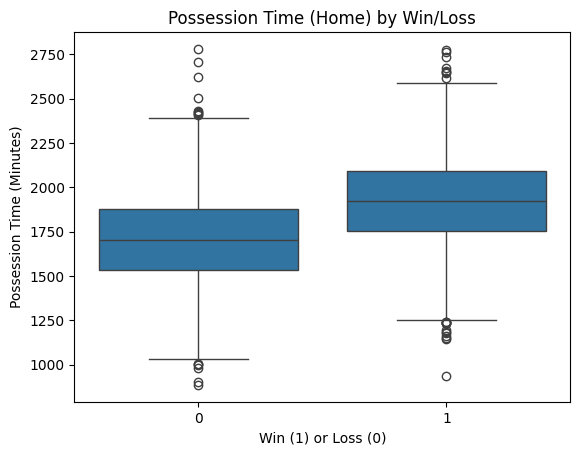

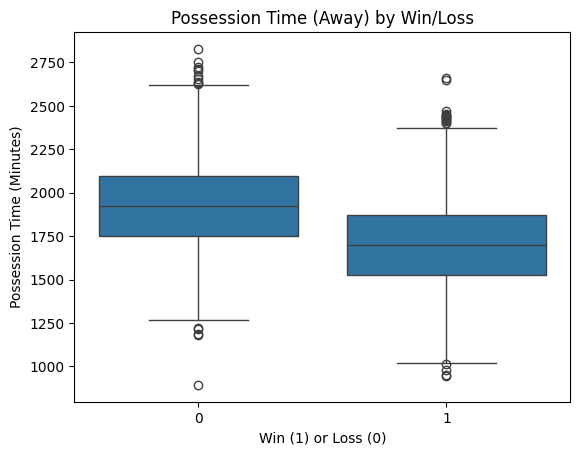

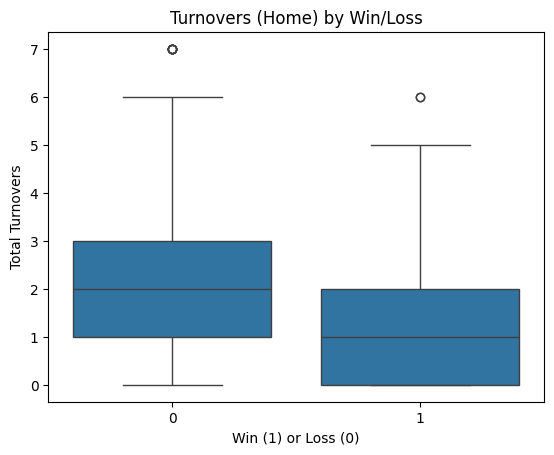

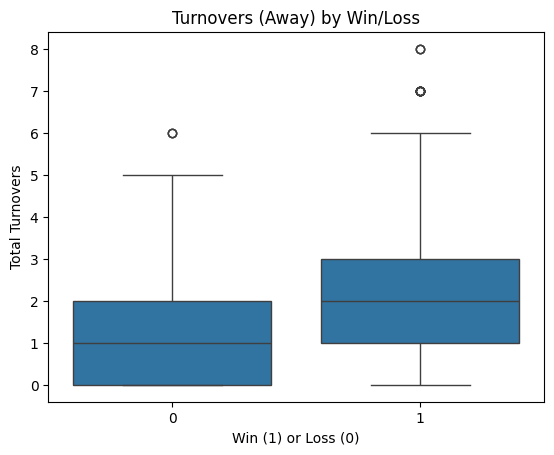

In [44]:
# Boxplot: possession time by win/loss
sns.boxplot(x='win_loss_home', y='possession_home', data=data)
plt.title('Possession Time (Home) by Win/Loss')
plt.xlabel('Win (1) or Loss (0)')
plt.ylabel('Possession Time (Minutes)')
plt.show()

sns.boxplot(x='win_loss_home', y='possession_away', data=data)
plt.title('Possession Time (Away) by Win/Loss')
plt.xlabel('Win (1) or Loss (0)')
plt.ylabel('Possession Time (Minutes)')
plt.show()

# Create total turnover metrics for home and away
data['turnovers_home'] = data['interceptions_home'] + data['fumbles_home']
data['turnovers_away'] = data['interceptions_away'] + data['fumbles_away']

# Boxplot for turnovers (home) by win/loss
sns.boxplot(x='win_loss_home', y='turnovers_home', data=data)
plt.title('Turnovers (Home) by Win/Loss')
plt.xlabel('Win (1) or Loss (0)')
plt.ylabel('Total Turnovers')
plt.show()

# Boxplot for turnovers (away) by win/loss
sns.boxplot(x='win_loss_home', y='turnovers_away', data=data)
plt.title('Turnovers (Away) by Win/Loss')
plt.xlabel('Win (1) or Loss (0)')
plt.ylabel('Total Turnovers')
plt.show()

## Observations: Performance by Win/Loss (Home Teams)

### Possession Time by Win/Loss
   1. **Home Teams**:
      - Winning teams generally have longer possession times than losing teams.
      - This highlights the importance of controlling the game clock and keeping the ball away from opponents.

   2. **Away Teams**:
      - A similar trend is observed, though the difference between winning and losing teams is less pronounced for away games.
      - Away teams may face greater challenges in maintaining possession due to home-field advantages for their opponents.

### Observations: Turnovers by Win/Loss
   1. **Home Teams**:
      - Losing teams commit significantly more turnovers (interceptions + fumbles) compared to winning teams.
      - Turnovers are a critical determinant of game outcomes, as they often lead to lost scoring opportunities or opponent points.

   2. **Away Teams**:
      - The trend is similar for away teams, though the effect is slightly less pronounced.
      - This reinforces the idea that minimizing turnovers is essential for success, especially in away games.

let's next flag outliers, aka high scoring games and high interceptions

let's find the threshold for what is considered an outlier value. Since in football a low scoring game or a low interception game isn't seen as an "outlier," we have the freedom to look at just the high outliers

looking it up online, the interquartile range can take care of our goal

In [45]:
# Calculate the IQR for score
score_q1_home = data['score_home'].quantile(0.25)
score_q3_home = data['score_home'].quantile(0.75)
score_iqr_home = score_q3_home - score_q1_home

score_q1_away = data['score_away'].quantile(0.25)
score_q3_away = data['score_away'].quantile(0.75)
score_iqr_away = score_q3_away - score_q1_away

# Define thresholds for high turnovers
score_upper_threshold_home = score_q3_home + 1.5 * score_iqr_home
score_upper_threshold_away = score_q3_away + 1.5 * score_iqr_away

print(f"Home Score Threshold: {score_upper_threshold_home}")
print(f"Away Score Threshold: {score_upper_threshold_away}")

# Calculate the IQR for turnovers
turnovers_q1_home = data['turnovers_home'].quantile(0.25)
turnovers_q3_home = data['turnovers_home'].quantile(0.75)
turnovers_iqr_home = turnovers_q3_home - turnovers_q1_home

turnovers_q1_away = data['turnovers_away'].quantile(0.25)
turnovers_q3_away = data['turnovers_away'].quantile(0.75)
turnovers_iqr_away = turnovers_q3_away - turnovers_q1_away

# Define thresholds for high turnovers
turnovers_upper_threshold_home = turnovers_q3_home + 1.5 * turnovers_iqr_home
turnovers_upper_threshold_away = turnovers_q3_away + 1.5 * turnovers_iqr_away

print(f"Home Turnover Threshold: {turnovers_upper_threshold_home}")
print(f"Away Turnover Threshold: {turnovers_upper_threshold_away}")

Home Score Threshold: 49.5
Away Score Threshold: 49.0
Home Turnover Threshold: 3.5
Away Turnover Threshold: 3.5


especially looking at the higher scope of outliers, let's round up; 

the score threshold will be 50, and turnover will be 4

In [46]:
# High-scoring games
high_scores = data[(data['score_home'] > 50) | (data['score_away'] > 50)]
print("Games with unusually high scores:")
print(high_scores[['season', 'week', 'away', 'home', 'score_away', 'score_home']])

Games with unusually high scores:
      season week      away      home  score_away  score_home
57      2002    4    Titans   Raiders          25          52
192     2002   14   Bengals  Panthers          31          52
325     2003    4     Colts    Saints          55          21
624     2004    7   Falcons    Chiefs          10          56
696     2004   12    Browns   Bengals          48          58
...      ...  ...       ...       ...         ...         ...
5553    2022   13     Colts   Cowboys          19          54
5597    2022   16   Broncos      Rams          14          51
5682    2023    3   Broncos  Dolphins          20          70
5852    2023   15  Chargers   Raiders          21          63
5890    2023   17  Dolphins    Ravens          19          56

[68 rows x 6 columns]


### Observations: High-Scoring Games

- Several games with unusually high scores (>50 points) were identified, which are likely anomalies or indicative of high-powered offensive matchups.
     - can be either one way like Broncos vs Dolphins or both ways in terms of offensive strength
- These games may disproportionately influence metrics like scoring averages and correlations, so they could be flagged for further analysis or excluded depending on modeling needs.


In [47]:
# Identify games with unusually high turnovers
high_turnovers = data[(data['turnovers_home'] > 4) | (data['turnovers_away'] > 4)]
print("Games with unusually high turnovers:")
print(high_turnovers[['season', 'week', 'away', 'home', 'turnovers_home', 'turnovers_away']])

Games with unusually high turnovers:
      season week      away        home  turnovers_home  turnovers_away
15      2002    1  Steelers    Patriots               1               5
30      2002    2   Raiders    Steelers               5               2
38      2002    3  Panthers     Vikings               5               2
42      2002    3   Packers       Lions               5               3
49      2002    4  Dolphins      Chiefs               0               5
...      ...  ...       ...         ...             ...             ...
5761    2023    8    Chiefs     Broncos               1               5
5772    2023    9     Bears      Saints               0               5
5797    2023   11    Giants  Commanders               6               0
5852    2023   15  Chargers     Raiders               0               5
5883    2023   16    Ravens       49ers               5               0

[325 rows x 6 columns]


Similar to high scoring games, high interceptions games may disproportionately influence metrics, so they could be flagged for further analysis or excluded depending on modeling needs 

let's also add more features that may be useful for the analysis, and see it's impact on the heatmap

In [48]:
# Red Zone Efficiency
data['redzone_efficiency_home'] = data['redzone_comp_home'] / data['redzone_att_home']
data['redzone_efficiency_away'] = data['redzone_comp_away'] / data['redzone_att_away']

# Yards per Play
data['yards_per_play_home'] = data['yards_home'] / data['plays_home']
data['yards_per_play_away'] = data['yards_away'] / data['plays_away']

# Check the new features
print(data[['redzone_efficiency_home', 'yards_per_play_home']].tail())

      redzone_efficiency_home  yards_per_play_home
5924                 0.750000             5.507042
5925                 0.750000             4.717949
5926                 0.000000             5.894737
5927                 0.800000             6.257576
5928                 0.333333             5.759494


### Derived Feature Insights
- `yards_per_play_home` and `yards_per_play_away` exhibit strong correlations with scores, underscoring their importance as offensive efficiency metrics.
- `redzone_efficiency_home` and `redzone_efficiency_away` are moderately correlated with scores, indicating that red zone performance is critical for winning games.

now, let's do a box plot for them

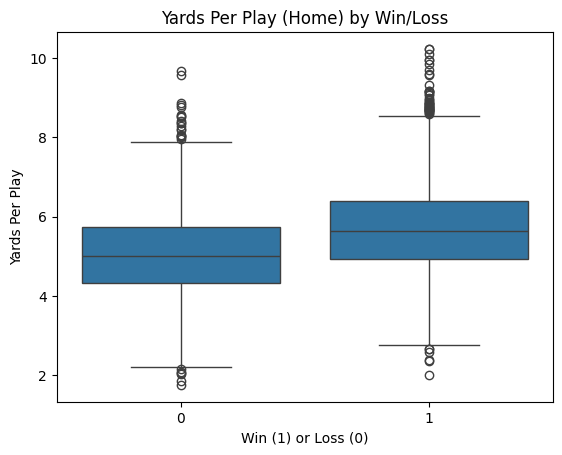

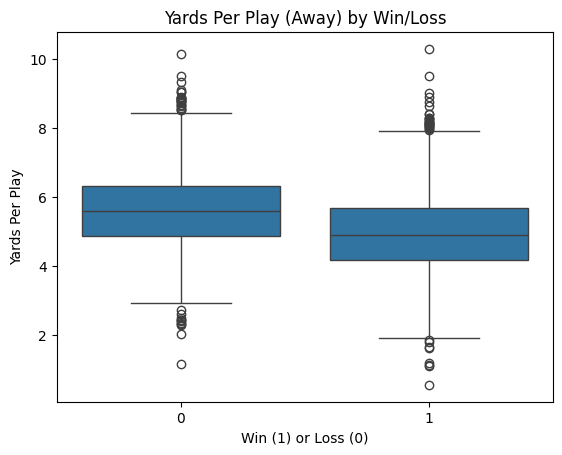

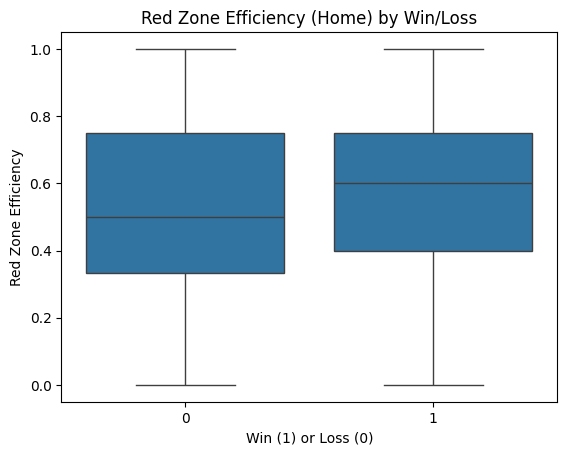

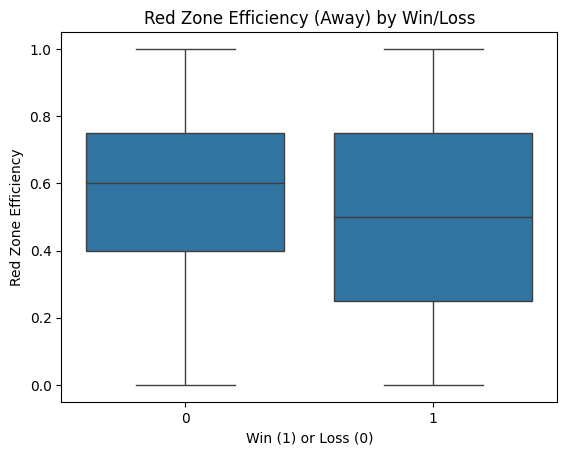

In [49]:
# Boxplot: yards per play by win/loss
sns.boxplot(x='win_loss_home', y='yards_per_play_home', data=data)
plt.title('Yards Per Play (Home) by Win/Loss')
plt.xlabel('Win (1) or Loss (0)')
plt.ylabel('Yards Per Play')
plt.show()

sns.boxplot(x='win_loss_home', y='yards_per_play_away', data=data)
plt.title('Yards Per Play (Away) by Win/Loss')
plt.xlabel('Win (1) or Loss (0)')
plt.ylabel('Yards Per Play')
plt.show()

# Boxplot: red zone efficiency by win/loss
sns.boxplot(x='win_loss_home', y='redzone_efficiency_home', data=data)
plt.title('Red Zone Efficiency (Home) by Win/Loss')
plt.xlabel('Win (1) or Loss (0)')
plt.ylabel('Red Zone Efficiency')
plt.show()

sns.boxplot(x='win_loss_home', y='redzone_efficiency_away', data=data)
plt.title('Red Zone Efficiency (Away) by Win/Loss')
plt.xlabel('Win (1) or Loss (0)')
plt.ylabel('Red Zone Efficiency')
plt.show()

### Observations: Yards Per Play by Win/Loss
1. **Home Teams**:
   - Winning teams have significantly higher yards per play, indicating efficient offensive production is key to success.
   - Losing teams show greater variability, reflecting inconsistencies in their offense.

2. **Away Teams**:
   - A similar trend is observed for away teams, though the difference between winning and losing teams is less pronounced.
   - This suggests away teams face more challenges maintaining high efficiency.

### Observations: Red Zone Efficiency by Win/Loss
1. **Home Teams**:
   - Winning teams consistently exhibit higher red zone efficiency compared to losing teams, underlining the importance of converting scoring opportunities.
   - Losing teams show greater variability, reflecting struggles to capitalize in high-pressure situations.

2. **Away Teams**:
   - Winning away teams also demonstrate higher red zone efficiency, though the gap between winning and losing teams is narrower.
   - This suggests that red zone performance is a critical factor for both home and away teams.


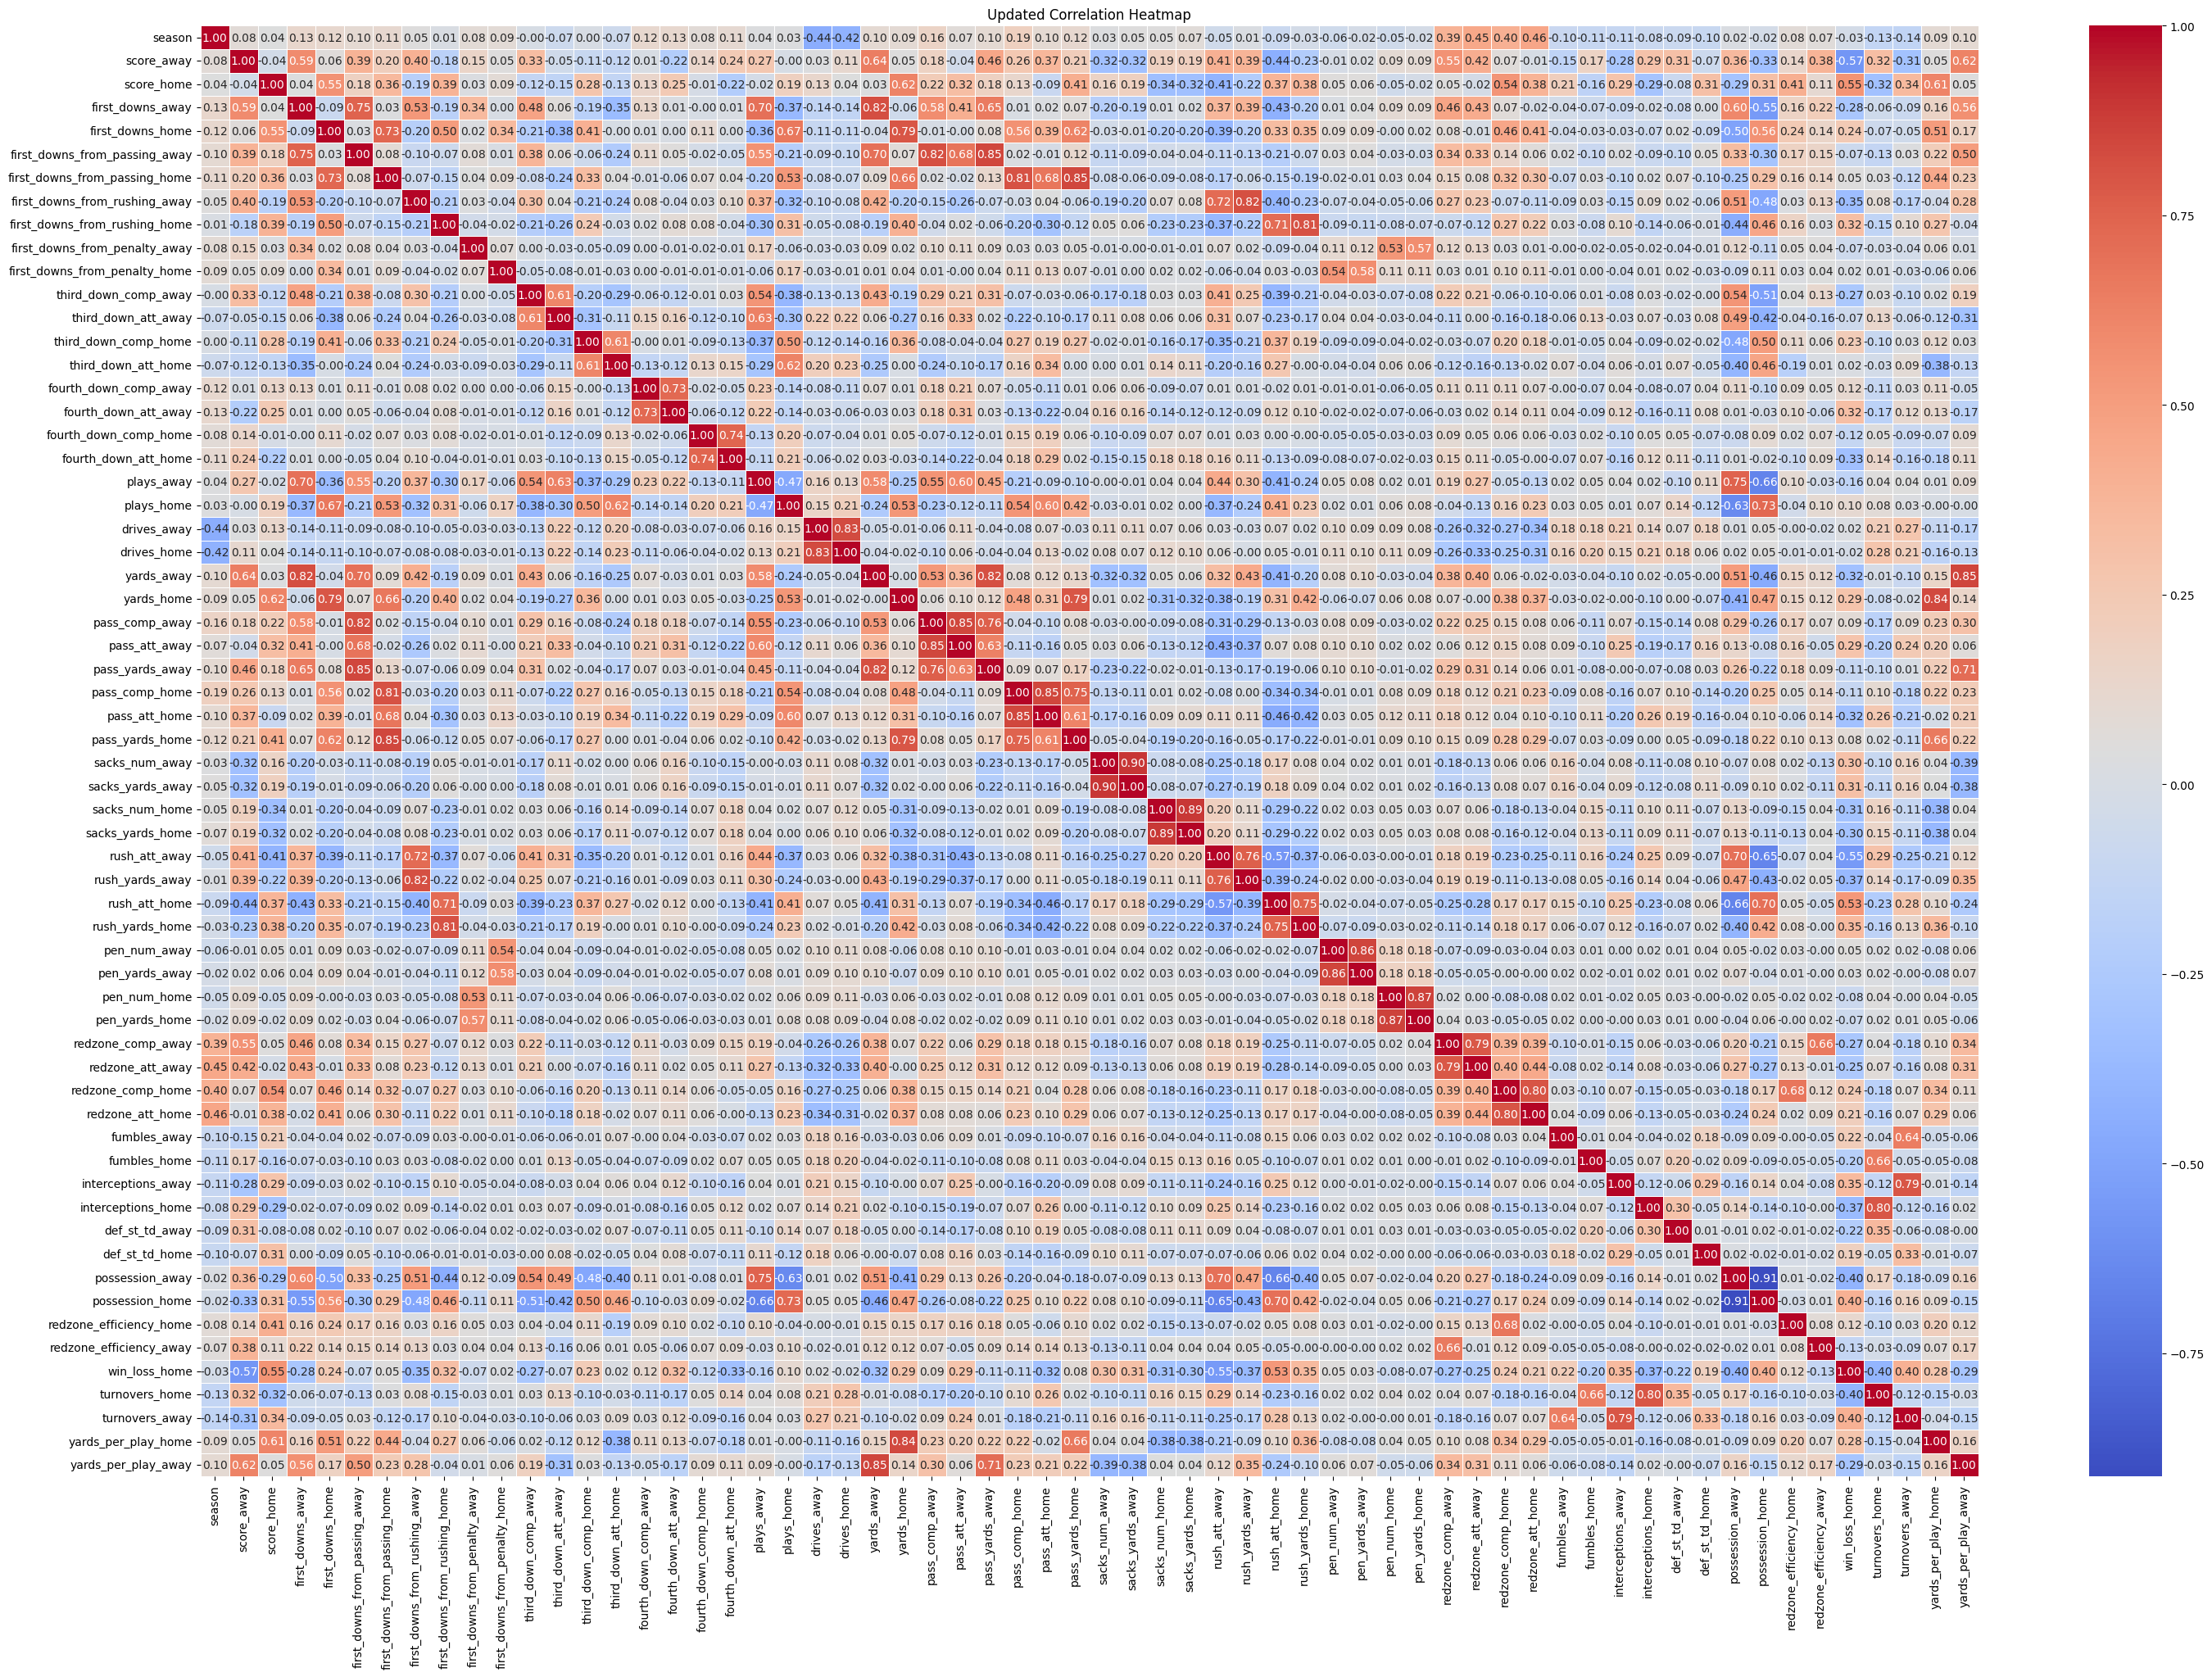

In [50]:
# Updated correlation heatmap
plt.figure(figsize=(35, 23))
updated_numeric_data = data.select_dtypes(include=['number'])
heatmap = sns.heatmap(
    updated_numeric_data.corr(), 
    annot=True, 
    fmt=".2f", 
    annot_kws={"size": 10}, 
    cmap='coolwarm', 
    linewidths=0.5
)
plt.title('Updated Correlation Heatmap')
plt.show()

### Observations: Derived Features
1. Red Zone Efficiency:
   - Teams with higher red zone efficiency are more likely to score consistently, as shown by its moderate-to-strong correlation with score_home.
2. Yards per Play:
   - Yards per play has a strong correlation with total yards and scores, confirming its importance in evaluating offensive strength.


Now, let's group our data visualizations along with results to select features

1. Offensive Metrics

yards_home (Total Offensive Yards for Home Teams):
- Strong correlation with score_home (around 0.6-0.7).
- Indicates the ability of a team to generate yardage through both passing and rushing.

yards_per_play_home (Offensive Efficiency):
- Derived feature combining yards_home and plays_home.
- Measures how effectively a team gains yards per play, which directly impacts scoring potential.

redzone_efficiency_home (Red Zone Conversion Rate):
- Derived feature indicating how often a team scores touchdowns in the red zone.
- A higher efficiency reflects a team’s ability to capitalize on scoring opportunities.

2. Defensive Metrics
interceptions_away (Away Team Turnovers):
- Turnovers by the away team give the home team more opportunities to score.
- Shows a negative impact on away team success, indirectly benefiting home teams.

def_st_td_home (Defensive/Special Teams Touchdowns for Home Teams):
- Indicates points scored by the defense or special teams, often game-changing plays.

3. Time of Possession
possession_home:
- Moderate correlation with score_home (around 0.3-0.4, moderate).
- Teams with longer possession tend to control the game flow, leading to higher chances of winning.

4. Turnovers
fumbles_away and fumbles_home:
- Turnovers are critical moments in any game.
- Fewer turnovers for the home team correlate positively with winning outcomes.

5. Scoring Metrics
score_home (Final Score for Home Teams):
- Although this is directly related to the win/loss outcome, it can also act as a key derived metric to study relationships between predictors like yards, possessions, and scoring.

so with that, here are the features that stand out for modeling win_loss_home:

Offensive Efficiency:
- yards_home
- yards_per_play_home
- redzone_efficiency_home

Defensive Impact:
- interceptions_away
- def_st_td_home

Possession and Turnovers:
- possession_home
- fumbles_home
- fumbles_away

Scoring Metrics:
- score_home (could be excluded if you want to predict without using final scores).

A fair question to ask is: why use home stats for offense and away for defense?

Home Offensive Stats:

- Features like yards_home, yards_per_play_home, and redzone_efficiency_home reflect the performance of the home team's offense, which directly impacts their scoring potential and chances of winning at home.
- **The home team's performance is typically more stable (less variability) due to the advantages of playing in familiar conditions, reduced travel, and crowd support.**

Away Defensive Stats:
- Metrics like interceptions_away and fumbles_away focus on away team mistakes or poor defensive performance that indirectly benefit the home team.
- **Away teams are more prone to turnovers and errors due to travel fatigue, hostile crowds, and unfamiliar environments.**

the columns such as "date", time_et, don't affect our data, so let's drop them

In [51]:
# Drop irrelevant columns
data.drop(columns=['date', 'time_et', 'neutral'], inplace=True)

we took care of a decent amount of EDA, let's save the cleaned dataset with getting rid of unneccesary columns and outliers

In [52]:
# thresholds for high interceptions and high scores
high_turnovers_condition = (data['turnovers_home'] > 4) | (data['turnovers_away'] > 4)
high_scores_condition = (data['score_home'] > 50) | (data['score_away'] > 50)

# (looked up) combine conditions to filter out high interception and high-scoring games
filtered_data = data[~(high_turnovers_condition | high_scores_condition)]

filtered_data.to_csv('../data/cleaned_nfl_team_stats.csv', index=False)

# Display summary of the filtered dataset
print(f"Original dataset size: {data.shape[0]} rows")
print(f"Cleaned dataset size: {filtered_data.shape[0]} rows")

print("Dataset saved for modeling.")

Original dataset size: 5929 rows
Cleaned dataset size: 5553 rows
Dataset saved for modeling.


check balance of win_loss_home

Win/Loss Distribution (Home Teams):
win_loss_home
1    0.564007
0    0.435993
Name: proportion, dtype: float64


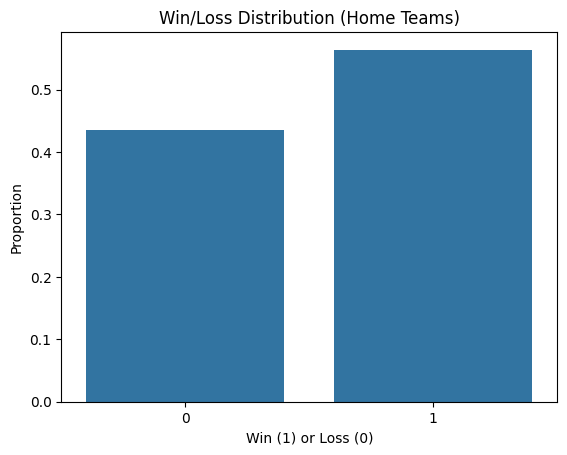

In [53]:
# Check class balance for win/loss
win_loss_distribution = data['win_loss_home'].value_counts(normalize=True)
print("Win/Loss Distribution (Home Teams):")
print(win_loss_distribution)

# Visualize class balance
sns.barplot(x=win_loss_distribution.index, y=win_loss_distribution.values)
plt.title('Win/Loss Distribution (Home Teams)')
plt.xlabel('Win (1) or Loss (0)')
plt.ylabel('Proportion')
plt.show()

### Class Balance
- The win_loss_home distribution shows slight imbalance, with more games resulting in wins for home teams.
- This imbalance will be addressed during modeling using techniques like class weighting or resampling.